__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Polygon

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_flat.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

24481


,title,adr,latitude,longitude,priceM,ts
3107,"2-к. квартира, 37 м², 1/1 эт.","Балаклава, Благодатная улица , 12/1",44.51,33.63,5.20,2022-08-26 17:29:00.000
3214,"3-к. квартира, 44,9 м², 2/2 эт.","Балаклава, улица Калича, 41",44.61,33.53,9.00,2022-08-26 17:29:00.000
17938,"2-к. квартира, 65,3 м², 7/8 эт.","улица Павла Корчагина, стр. 1",44.58,33.43,12.10,2022-09-13 13:55:03.079


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24481 entries, 0 to 24480
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   avito_id       18459 non-null  float64       
 1   title          24481 non-null  object        
 2   price          24481 non-null  int64         
 3   adr            24481 non-null  object        
 4   description    24481 non-null  object        
 5   obj_name       24481 non-null  object        
 6   ts             24481 non-null  datetime64[ns]
 7   avito_page     18459 non-null  float64       
 8   nrooms         24481 non-null  int64         
 9   floor          24481 non-null  int64         
 10  nfloors        24481 non-null  int64         
 11  area           24481 non-null  float64       
 12  is_studio      24481 non-null  bool          
 13  is_apartment   24481 non-null  bool          
 14  is_part        24481 non-null  bool          
 15  is_auction     2448

In [7]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

24481
24481


In [8]:
# # берём самые свежие объявления
# print(len(df))
# df = df[ (df['ts']==df['ts'].max()) ].reset_index(drop=True)
# print(len(df))

In [9]:
# cols = ['title','adr','latitude','longitude','priceM']
# df[cols]

### ограничиваем тип объекта 

In [10]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))

24481
20193


In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
23284,"1-комн. кв., 49,1 м², 1/4 этаж","Севастополь, район Гагаринский, микрорайон Летчики, улица Астана Кесаева, 3",44.60,33.46,6.00
12579,"2-к. квартира, 42,8 м², 1/5 эт.","улица Маршала Крылова, 21",44.85,33.65,5.70
21180,"1-комн. кв., 30,9 м², 2/5 этаж","Севастополь, район Нахимовский, микрорайон Радиогорка, улица Михайловская, 15",44.63,33.53,4.25


In [12]:
del df

## общая статистика изменение цены

In [13]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['nrooms','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)

stat

count  mean  std  min   10%   25%   50%   75%   90%    max
nrooms dt                                                                     
1      2022-08-26 1203.00  6.26 1.91 1.59  4.07  5.00  6.00  7.30  8.50  18.50
       2022-08-29 1191.00  6.25 1.90 1.75  4.11  5.00  6.00  7.21  8.50  18.50
       2022-08-31 1180.00  6.34 1.92 1.30  4.20  5.09  6.00  7.43  8.76  18.50
       2022-09-01 1159.00  6.32 1.89 1.30  4.15  5.10  6.00  7.40  8.51  18.50
       2022-09-02  365.00  6.31 2.10 3.65  4.00  4.85  5.81  7.21  9.35  14.90
       2022-09-05  372.00  6.21 2.10 3.10  3.99  4.81  5.55  7.07  9.35  14.90
       2022-09-06  372.00  6.22 2.10 3.15  3.99  4.83  5.62  7.05  9.33  14.90
       2022-09-07  320.00  6.35 2.10 3.10  4.09  4.87  5.80  7.26  9.35  14.90
       2022-09-08 1031.00  5.92 2.35 1.40  3.50  4.25  5.42  7.10  9.00  18.50
       2022-09-12  906.00  5.89 2.35 1.40  3.49  4.40  5.42  7.00  8.70  18.50
       2022-09-13  910.00  5.96 2.41 1.40  3.40  4.30  5.50  7.20  9.12  18.50
       2022-09-15  916.00  5.91 2.30 1.40  3.49  4.45  5.50  7.00  8.86  18.50
2      2022-08-26  941.00  8.82 3.30 2.80  5.80  6.60  8.15 10.21 12.67  36.00
       2022-08-29  936.00  8.87 3.30 2.80  5.88  6.70  8.19 10.42 12.64  36.00
       2022-08-31  925.00  8.83 3.20 2.60  5.80  6.69  8.10 10.35 12.85  35.00
       2022-09-01  947.00  8.91 3.32 2.65  5.80  6.70  8.18 10.50 12.90  36.00
       2022-09-02  112.00  9.66 2.65 4.91  6.36  7.55  9.43 11.53 12.97  15.70
       2022-09-05  131.00  9.76 2.70 4.92  6.40  8.00  9.28 11.37 13.65  15.70
       2022-09-06  187.00  9.71 2.69 4.91  6.32  7.83  9.28 11.45 13.65  15.70
       2022-09-07  128.00  9.75 2.85 4.91  6.20  7.49  9.14 11.77 13.93  15.70
       2022-09-08  560.00  9.44 4.16 3.20  6.00  6.74  8.39 11.13 13.65  49.12
       2022-09-12  476.00  9.25 4.34 3.00  5.70  6.60  8.22 10.88 13.63  49.12
       2022-09-13  474.00  9.16 4.38 3.00  5.65  6.54  8.18 10.61 13.60  49.12
       2022-09-15  495.00  9.10 4.16 3.00  5.90  6.60  8.18 10.60 13.58  49.12
3      2022-08-26  646.00 11.61 6.14 3.50  7.40  8.30 10.25 13.24 16.80 100.00
       2022-08-29  635.00 11.66 6.17 3.85  7.40  8.43 10.33 13.28 16.68 100.00
       2022-08-31  640.00 11.64 6.12 3.85  7.40  8.44 10.30 13.03 17.03 100.00
       2022-09-01  634.00 11.57 6.13 3.85  7.40  8.30 10.21 13.00 16.90 100.00
       2022-09-02   61.00 11.17 1.74 7.73 10.21 10.33 10.35 11.53 13.90  16.64
       2022-09-05   67.00 11.22 1.85 7.73 10.21 10.33 10.35 12.03 14.18  16.64
       2022-09-06   65.00 11.22 1.87 7.73 10.21 10.33 10.34 11.53 14.27  16.64
       2022-09-07   58.00 11.26 1.81 9.20 10.21 10.33 10.35 11.35 14.13  16.64
       2022-09-08  298.00 11.98 5.67 5.00  7.64  9.15 10.35 13.50 17.36  56.52
       2022-09-12  273.00 11.99 6.02 5.00  7.60  9.00 10.33 13.50 17.40  56.52
       2022-09-13  292.00 12.06 5.88 5.00  7.60  9.00 10.35 13.50 17.00  56.52
       2022-09-15  287.00 11.76 5.85 4.70  7.50  9.00 10.34 12.80 16.66  56.52

<AxesSubplot:title={'center':'цена на 1к'}, xlabel='dt'>

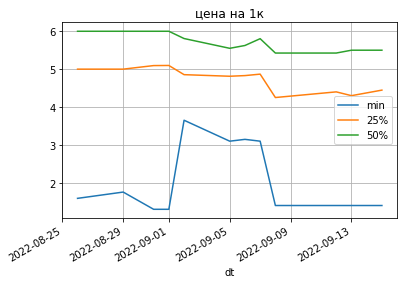

In [14]:
stat.loc[1,['min','25%','50%']].plot(grid=True, title='цена на 1к')

<AxesSubplot:title={'center':'цена на 2к'}, xlabel='dt'>

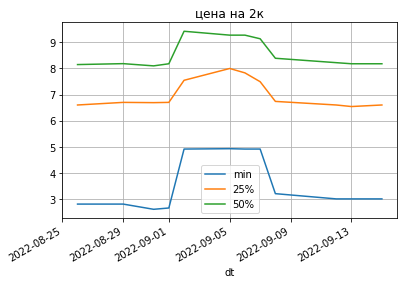

In [15]:
stat.loc[2,['min','25%','50%']].plot(grid=True, title='цена на 2к')

<AxesSubplot:title={'center':'цена на 3к'}, xlabel='dt'>

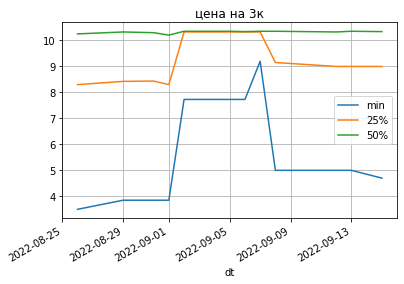

In [16]:
stat.loc[3,['min','25%','50%']].plot(grid=True,title='цена на 3к')

## ограничиваем по район поиска

In [17]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')
# frames_index

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames['area_id'] = range(len(frames))

frames

,area_name,geometry,area_id
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))",0
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))",1
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))",2
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))",3
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))",4
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))",5


<AxesSubplot:>

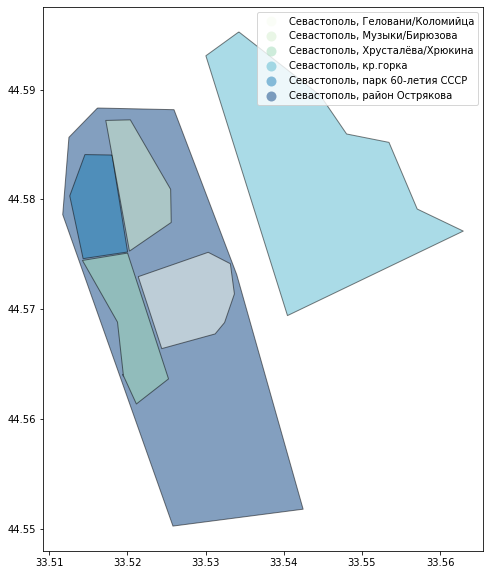

In [18]:
frames.plot('area_name', legend=True, cmap='GnBu', alpha=.5, edgecolor='k',figsize=(10,10),)  

In [19]:
frames.explore('area_name', legend=True)

In [20]:
# ctx.add_basemap(
#     frames.plot('area_name',legend=True,cmap='GnBu',figsize=(31,31),alpha=.5,edgecolor='k'), 
#     crs=gdf.crs, 
#     zoom=16,
#     source=ctx.providers.OpenStreetMap.Mapnik,
# )

In [21]:
# фильтруем по области
print(len(gdf))
gdf_in_frame = gdf.sjoin( frames.query('area_id in (1,2)'), how='inner', predicate='within') 
print(len(gdf_in_frame))

20193
993


In [22]:
gdf_in_frame[['title','priceM','adr','geometry']].explore( legend=False)

In [23]:
# ctx.add_basemap(
#     gdf_in_frame[ (gdf_in_frame['dt']==gdf_in_frame['dt'].max()) ]
#       .plot(figsize=(21,21), color='r',marker='*'), 
#     crs=gdf.crs, 
#     zoom=16,
#     # source=ctx.providers.Stamen.TonerLite,
#     source=ctx.providers.OpenStreetMap.Mapnik,
# )

### изменение цены

In [24]:
stat = gdf_in_frame.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
stat

count  mean  std  min  10%  25%  50%   75%   90%   max
nrooms dt                                                                
1      2022-08-26 103.00  5.13 2.31 3.10 3.67 3.91 4.22  5.33  8.32 14.90
       2022-08-29 102.00  5.31 2.45 3.10 3.67 3.91 4.24  5.50  8.67 14.90
       2022-08-31  92.00  5.39 2.46 3.10 3.65 3.91 4.40  5.50  8.67 14.25
       2022-09-01  96.00  5.14 2.32 3.10 3.67 3.91 4.17  5.50  8.50 14.25
       2022-09-02  69.00  5.33 2.98 3.65 3.67 3.87 3.99  5.01  9.15 14.90
       2022-09-05  73.00  5.14 2.98 3.10 3.65 3.91 3.99  4.24  8.93 14.90
       2022-09-06  77.00  5.28 2.95 3.15 3.67 3.88 4.02  4.29  8.93 14.90
       2022-09-07  53.00  5.55 3.25 3.10 3.65 3.88 3.95  5.01  9.73 14.90
       2022-09-08  76.00  5.34 3.08 3.10 3.72 3.91 3.99  4.25  9.44 14.90
       2022-09-12  26.00  7.03 4.06 3.10 3.65 3.93 4.24  8.94 13.72 14.90
       2022-09-13  27.00  6.75 3.83 3.10 3.66 3.93 4.24  8.91 13.66 14.90
       2022-09-15  26.00  6.24 3.27 3.10 3.63 3.94 4.24  8.82  9.44 14.90
2      2022-08-26  28.00  7.61 1.54 5.30 6.15 6.38 7.50  8.50  9.49 11.00
       2022-08-29  31.00  7.50 1.52 5.30 5.85 6.35 6.70  8.50  9.50 11.00
       2022-08-31  28.00  7.22 1.22 5.30 6.08 6.38 6.60  8.22  8.74  9.50
       2022-09-01  30.00  7.56 1.51 5.30 6.16 6.50 6.85  8.50  9.50 11.00
3      2022-08-26  15.00 10.75 4.30 7.00 7.35 7.70 8.00 14.40 17.16 19.00
       2022-08-29  15.00 10.78 4.28 7.00 7.35 7.65 8.30 14.40 17.16 19.00
       2022-08-31  12.00 10.79 4.44 7.00 7.28 7.57 8.22 14.20 17.68 19.00
       2022-09-01  14.00 10.93 4.41 7.00 7.33 7.60 8.22 14.60 17.37 19.00

<AxesSubplot:title={'center':'цена на 1к'}, xlabel='dt'>

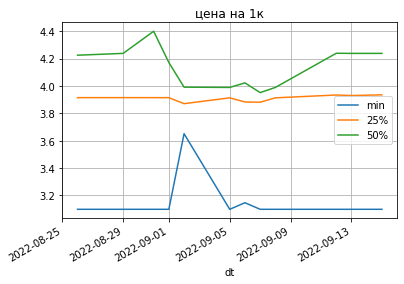

In [25]:
stat.loc[1,['min','25%','50%']].plot(grid=True, title='цена на 1к')

<AxesSubplot:title={'center':'цена на 2к'}, xlabel='dt'>

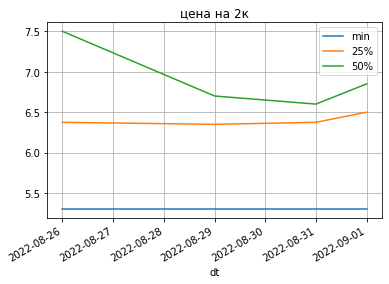

In [26]:
stat.loc[2,['min','25%','50%']].plot(grid=True, title='цена на 2к')

<AxesSubplot:title={'center':'цена на 3к'}, xlabel='dt'>

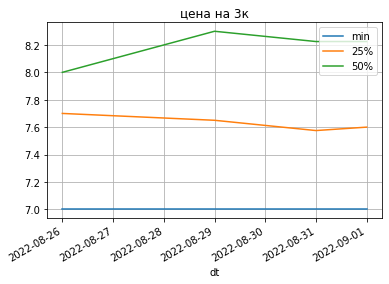

In [27]:
stat.loc[3,['min','25%','50%']].plot(grid=True,title='цена на 3к')

## гексагональная сетка

In [28]:
import h3
    
def cover_grid_hexagonal(gmtr,cell_size=9,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame(
        { 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },
        crs=crs, 
    )

grid = cover_grid_hexagonal( frames.query('area_id==0').geometry.values[0] )
print(len(grid))
grid.sample(2)

54


,hex_id,geometry
35,892d2895523ffff,"POLYGON ((33.52029 44.56100, 33.51997 44.55921, 33.52205 44.55804, 33.52446 44.55867, 33.52479 44.56046, 33.52270 44.56162, 33.52029 44.56100))"
53,892d2894047ffff,"POLYGON ((33.52066 44.58838, 33.52034 44.58659, 33.52243 44.58542, 33.52484 44.58605, 33.52516 44.58784, 33.52307 44.58900, 33.52066 44.58838))"


In [29]:
# ctx.add_basemap( 
#     grid.plot(alpha=.5,color='yellow',edgecolors='blue',figsize=(31,31),), 
#     source=ctx.providers.OpenStreetMap.Mapnik,
#     crs=grid.crs, 
#     zoom=16,
# )

### медиана актуальной цены

In [30]:
ts = '2022-08-01' # ограничиваем дату

In [31]:
grid_values = (
    grid.sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM') #'area_name', legend=True)

### количество предложений

In [32]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {  return false; }

<IPython.core.display.Javascript object>

In [33]:
# количество предложений
from folium import Map
from folium.plugins import HeatMap

start_pos = (44.578330, 33.516509)

Map(
    location=start_pos,
    zoom_start=15,
    # width=500,
    #height=2000,
).add_child( 
    HeatMap( 
        gdf[ gdf['dt']>ts ]
        .sjoin(frames,how='inner',predicate='within')[['latitude','longitude',]],
        #radius=10.,
        #min_opacity=3. 
    )
)


In [34]:
# gdf

In [35]:
grid_values = (
    grid.sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

# grid.merge(grid_values,on='hex_id').explore('priceM') #'area_name', legend=True)


In [36]:
# grid_values

In [37]:
# grid

In [38]:
# grid_values.sample(2)
# grid.sample(2)

In [39]:
import folium

# Create a map
my_map = folium.Map(location=start_pos, zoom_start=14,)

# Add the data
folium.Choropleth(
    name='choropleth',
    geo_data=grid,
    data=grid_values,
    columns=['hex_id','priceM',],
    key_on='feature.properties.hex_id',
    fill_color='YlOrRd',
    fill_opacity=.7,
    line_opacity=.2,
    legend_name='priceM median'
).add_to(my_map)
my_map

In [40]:
#grid.merge(grid_values).explode(
    #'priceM', 
    #alpha=.5,
    #edgecolors='blue',
    # cmap='rainbow',
    #figsize=(31,31), 
    #legend=True, 
#)

# ax.set(title='медиана цены (в млн.руб.)')

# ctx.add_basemap( 
#     ax,
#     source=ctx.providers.OpenStreetMap.Mapnik,
#     crs=grid.crs, 
#     zoom=16,
# )


# frid.explore('area_name', legend=True)